<a href="https://colab.research.google.com/github/Biglasagna/Repo_test/blob/main/Projet_Diabete_UE_Bioinfo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
# Proposition d'un modèle de deep learning pour la classification patients/contrôles pour le diabète de type 1 à partir de données phénotypiques.
---


Etapes du code :

* Présentation des données
* Visualisation des données
* Préparation des données
* Création du modèle et entrainement
* Visualisation de l'entrainement
* Test
* Visualisation des résultats

> URL de l'inspiration : https://www.kaggle.com/code/danishmubashar/diabetes-hypertension-predict-acc-97



## 1.1 | Introduction:

La prédiction d'un état patient/non patient fiable à partir de données faciles d'obtention est un défis difficile pour les practiciens et de plus en plus étudié dans le domaine
 de la recherche en deeplearning. La capacité des modèles en réseau de neurones de procéder à un apprentissage sans apriori sur les données en fait un redoutable outil qui ne laisse rien au hasard et est bien plus robuste que d'autres algorithmes lorsque l'on traite de corrélation  non linéaires entre état et variables. En contrepartie, ce genre d'algorithmes necessitent à la fois un jeu de données informatif et le plus grand possible, de pair avec des capacités calculatoires de plus en plus grandes. Ici, nous essayerons d'appliquer un réseau de neurone circonvolutionnel (CNN) afin de prédire l'état patient/contrôle pour le diabète myelitus. Pour cela, nous nous basons sur un ensemnble de données qualitatives ou continues issues de mesures simples et de prise de sang.

## 1.2 | Choix du jeu de données:


The Pima Indians Diabetes Dataset is a publicly available test dataset widely used for diabetes research and predictive modeling. It contains 768 observations of females of Pima Indian heritage aged 21 years or older. The dataset includes eight medical predictor variables and one target variable. The predictor variables are:

Pregnancies: Number of times pregnant
Glucose: Plasma glucose concentration over 2 hours in an oral glucose tolerance test
Blood Pressure: Diastolic blood pressure (mm Hg)
Skin Thickness: Triceps skinfold thickness (mm)
Insulin: 2-hour serum insulin (mu U/ml)
BMI: Body mass index (weight in kg/(height in m)^2)
Diabetes Pedigree Function: A function that scores the likelihood of diabetes based on family history
Age: Age in years


## 1.3 | Analyses descriptives

- ### Import des librairies



In [9]:
#  import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [16]:

df = pd.read_csv("https://raw.githubusercontent.com/Biglasagna/Repo_test/refs/heads/main/diabetes_prediction_dataset.csv/diabetes_prediction_dataset.csv")
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [17]:
# check for descriptive statistics
df.describe()
# remove duplicate values
df = df.drop_duplicates()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


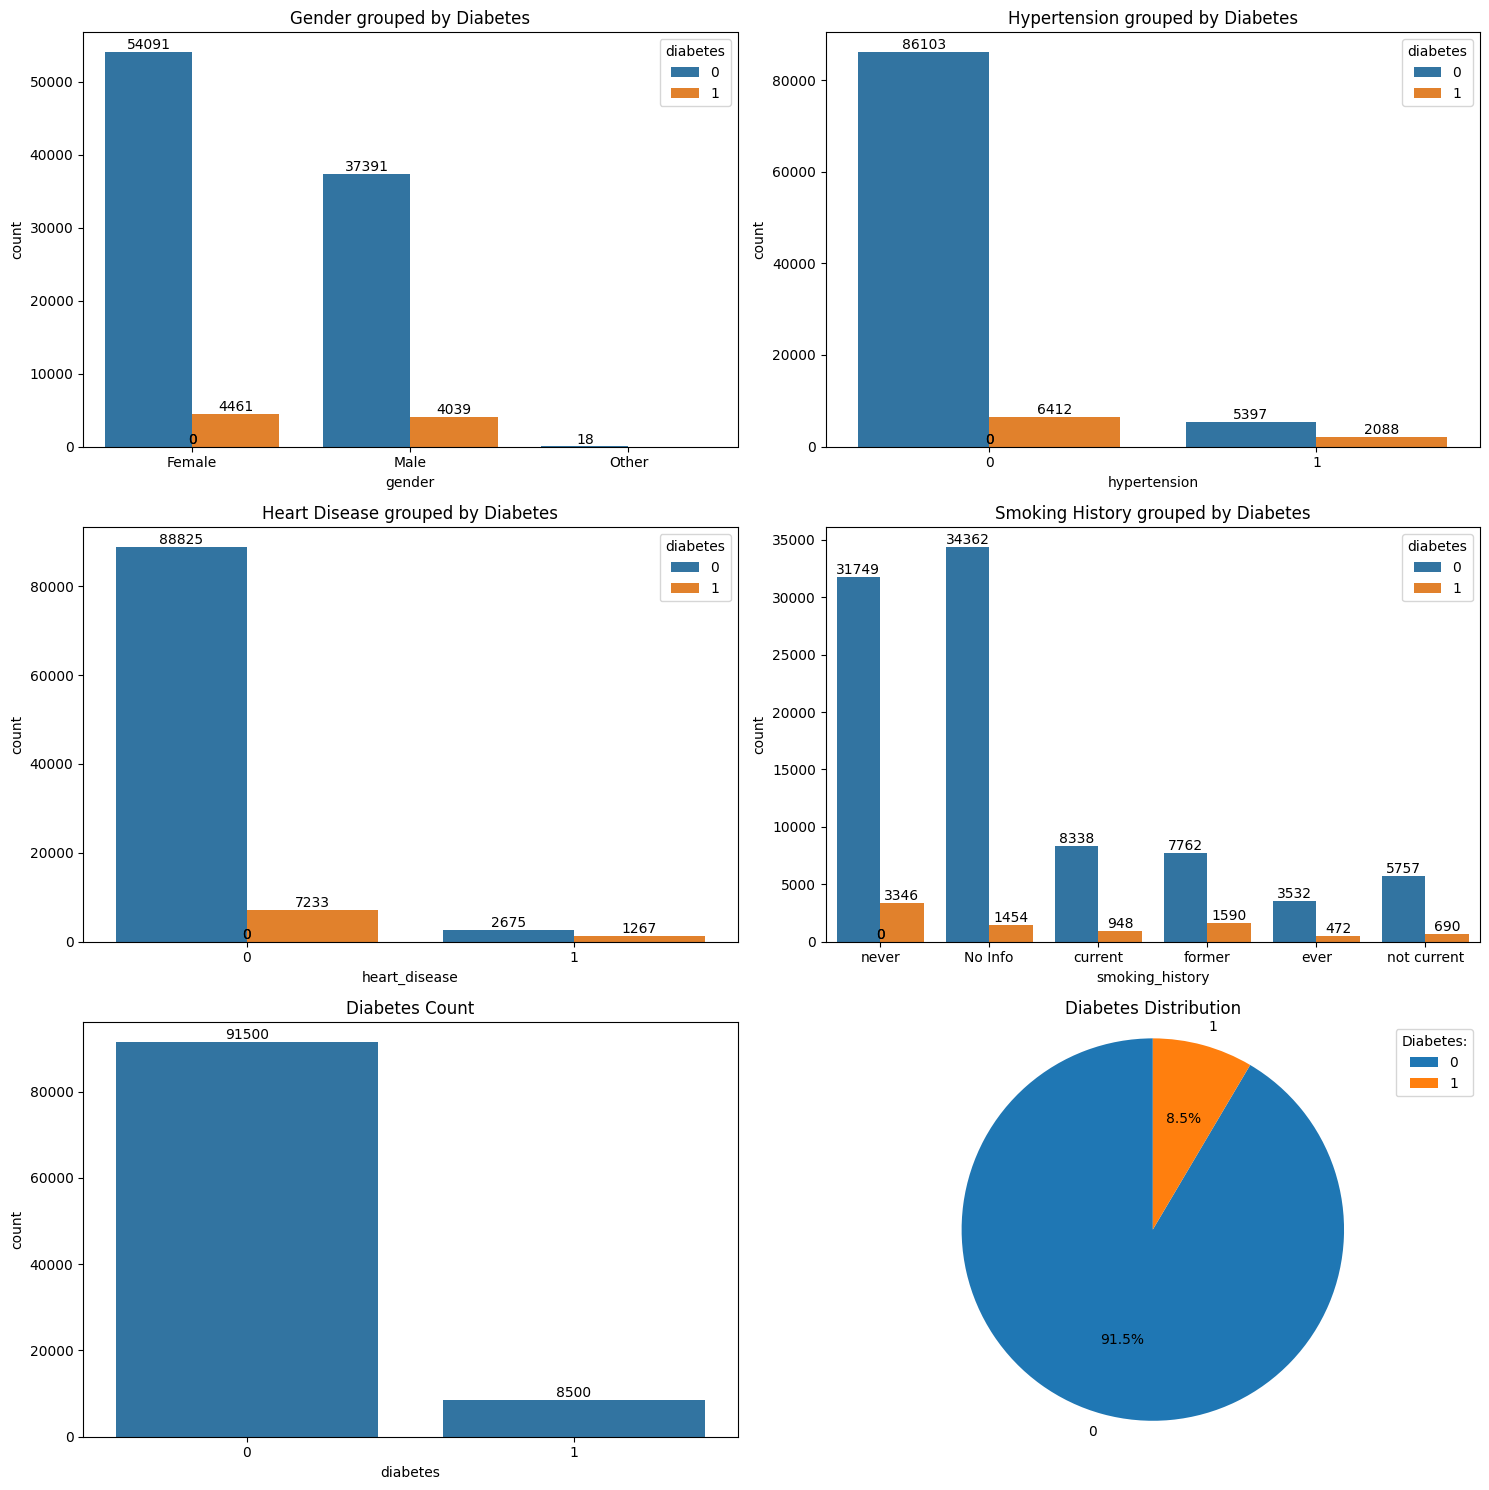

In [18]:
# Function to add counts on bars
def add_counts(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Set up the matplotlib figure
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot gender grouped by diabetes
ax = sns.countplot(ax=axes[0, 0], x='gender', hue='diabetes', data=df)
axes[0, 0].set_title('Gender grouped by Diabetes')
add_counts(ax)

# Plot hypertension grouped by diabetes
ax = sns.countplot(ax=axes[0, 1], x='hypertension', hue='diabetes', data=df)
axes[0, 1].set_title('Hypertension grouped by Diabetes')
add_counts(ax)

# Plot heart disease grouped by diabetes
ax = sns.countplot(ax=axes[1, 0], x='heart_disease', hue='diabetes', data=df)
axes[1, 0].set_title('Heart Disease grouped by Diabetes')
add_counts(ax)

# Plot smoking history grouped by diabetes
ax = sns.countplot(ax=axes[1, 1], x='smoking_history', hue='diabetes', data=df)
axes[1, 1].set_title('Smoking History grouped by Diabetes')
add_counts(ax)

# Plot diabetes
ax = sns.countplot(ax=axes[2, 0], x='diabetes', data=df)
axes[2, 0].set_title('Diabetes Count')
add_counts(ax)

# Create pie plot for diabetes
diabetes_counts = df['diabetes'].value_counts()
axes[2, 1].pie(diabetes_counts, labels=diabetes_counts.index, autopct='%1.1f%%', startangle=90)
axes[2, 1].set_title('Diabetes Distribution')
axes[2, 1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
axes[2, 1].legend(title='Diabetes:', loc='upper right')
# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

Interprétation